In [1]:
import os
import sys
import json
import time
import copy
import torch
import random
import logging
import warnings
import datetime
import torch.optim as opt

import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from sklearn import linear_model
from torch.autograd import grad, Variable
from torch.autograd.functional import vhp
from torch.utils.data import Subset, DataLoader
from data_processing import get_data_adult
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

warnings.filterwarnings("ignore")
device = f"cuda:5"


WEIGHT_DECAY = 1e-5
TEST_INDEX = 5
RECURSION_DEPTH = 2623
SAMPLE_NUM = 100
R = 10

plt.rcParams['figure.dpi'] = 300

criterion = torch.nn.BCELoss()
train_dataloader, test_dataloader, num_features, train_dataset, all_data = get_data_adult(batch_size=256, randomize='false', epsilon=0.2)
train_data_features, train_data_labels, test_data_features, test_data_labels = all_data

91
90


### Utility Functions

In [2]:
def graph(data, acc_or_l, train_or_test, lr, batch_size):
    sns.set(font_scale=1)

    plt.plot(data, 'b-', linewidth=2.0)

    plt.xlabel('Epoch')
    plt.ylabel(acc_or_l)
    plt.title(train_or_test + ' ' + acc_or_l + ' lr: ' + str(lr) + ' batch: ' + str(batch_size))
    plt.tight_layout()
    plt.show()

In [3]:
def set_random():
    random.seed(0)
    os.environ["PYTHONHASHSEED"] = str(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

### Models

In [4]:
class LogisiticRegression(torch.nn.Module):
    def __init__(self, weight_decay, num_feat):
        super(LogisiticRegression, self).__init__()

        self.wd = torch.FloatTensor([weight_decay]).cuda()
        self.w = torch.nn.Parameter(torch.zeros([num_feat], requires_grad=True))

    def forward(self, x):
        logits = torch.matmul(x, torch.reshape(self.w, [-1, 1]))

        return logits

    def loss(self, logits, y, train=True):
        preds = torch.sigmoid(logits)

        if train:
            loss = -torch.mean(y * log_clip(preds) + (1 - y) * log_clip(1 - preds)) # + torch.norm(self.w, 2) * self.wd
        else:
            loss = -torch.mean(y * log_clip(preds) + (1 - y) * log_clip(1 - preds))

        return loss

### Influence Calculation Functions


In [5]:
def calc_influence_single(model, train_loader, test_loader, test_id_num, recursion_depth, r, loss_func):
    
    # calculate s_test vectors
    x_test, y_test = test_loader.dataset[test_id_num]
    x_test = test_loader.collate_fn([x_test])
    y_test = test_loader.collate_fn([y_test])
    s_test_vec = s_test_sample(model, x_test, y_test, train_loader, recursion_depth, r, loss_func)
    
    train_dataset_size = len(train_loader.dataset)
    influences = []
    
    for i in tqdm(range(train_dataset_size)):
        x, y = train_loader.dataset[i]
        x = train_loader.collate_fn([x])
        y = train_loader.collate_fn([y])
        
        grad_x_vec = grad_x(x, y, model, loss_func)
        
        with torch.no_grad():
            tmp_influence = (
                -sum([torch.sum(k * j).data
                        for k, j in zip(grad_x_vec, s_test_vec)
                    ]
                )
                / train_dataset_size
            )
            
        influences.append(tmp_influence)
    
    harmful = np.argsort([inf.cpu() for inf in influences])
    helpful = harmful[::-1]
    
    return influences, harmful.tolist(), helpful.tolist(), test_id_num

In [6]:
def s_test_sample(model, x_test, y_test, train_loader, recursion_depth, r, loss_func):
    inverse_hvp = [torch.zeros_like(params, dtype=torch.float) for params in model.parameters()]
    
    for i in range(r):
        hessian_loader = DataLoader(train_loader.dataset, 
                                    sampler=torch.utils.data.RandomSampler(train_loader.dataset,
                                                                           True,
                                                                           num_samples = recursion_depth),
                                   batch_size = 1,
                                   num_workers = 4
                                   )
        cur_estimate, scale = s_test(x_test, y_test, model, i, hessian_loader, loss_func)
        
        with torch.no_grad():
            inverse_hvp = [old + (cur / scale) for old, cur in zip(inverse_hvp, cur_estimate)]

    with torch.no_grad():
        inverse_hvp = [component / r for component in inverse_hvp]

    return inverse_hvp

In [7]:
def grad_x(x_test, y_test, model, loss_func):
    model.eval()
    x_test, y_test = x_test.type(torch.FloatTensor).to(device), y_test.type(torch.FloatTensor).to(device)
    prediction = model(x_test)
    
    loss = calc_loss(prediction, y_test, loss_func)
    
    return grad(loss, model.parameters())

In [8]:
def s_test(x_test, y_test, model, i, sample_loader, loss_func):
    damp = 0
    scale = 25
    
    v = grad_x(x_test, y_test, model, loss_func)
    h_estimate = v
    
    params, names = make_functional(model)
    
    params = tuple(p.detach().requires_grad_() for p in params)
    
    progress_bar = tqdm(sample_loader, desc=f"IHVP sample {i+1}")
    
    for i, (x_train, y_train) in enumerate(progress_bar):
        x_train, y_train = x_train.type(torch.FloatTensor).to(device), y_train.type(torch.FloatTensor).to(device)
        
        def f(*new_params):
            load_weights(model, names, new_params)
            out = model(x_train)
            loss = calc_loss(out, y_train, loss_func)
            return loss
        
        hv = vhp(f, params, tuple(h_estimate), strict=True)[1]
        
        with torch.no_grad():
            h_estimate = [
                _v + (1 - damp) * _h_e - _hv / scale
                for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]

            if i % 100 == 0:
                norm = sum([h_.norm() for h_ in h_estimate])
                progress_bar.set_postfix({"est_norm": norm.item()})
    
    with torch.no_grad():
        load_weights(model, names, params, as_params=True)
    
    return h_estimate, scale


In [9]:
def calc_loss(prediction, y_test, loss_func):
    if loss_func == "cross_entropy":
        if prediction.shape[-1] == 1:
            criterion = torch.nn.BCEWithLogitsLoss()
            loss = criterion(prediction.ravel(), y_test.type(torch.float))
        else:
            criterion = torch.nn.cross_entropy()
            loss = criterion(prediction, y_test)
    elif loss_func == "BCELoss":
        criterion = torch.nn.BCELoss()
        loss = criterion(prediction.ravel(), y_test)
        
    return loss

In [10]:
def make_functional(model):
    orig_params = tuple(model.parameters())
    names = []
    
    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)
    
    return orig_params, names

In [11]:
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])

In [12]:
def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)

In [13]:
def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

### Perform Influence Calculation and LOO

In [14]:
def LOO():
    train_sample_num = len(train_data_features)
    
    class CreateData(torch.utils.data.Dataset):
        def __init__(self, data, targets):
            self.data = data
            self.targets = targets

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            out_data = self.data[idx]
            out_label = self.targets[idx]

            return out_data, out_label
    
    train_data = CreateData(train_data_features, train_data_labels)
    loo_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

    # prepare sklearn model to train w
    C = 1.0 / (train_sample_num * WEIGHT_DECAY)
    sklearn_model = linear_model.LogisticRegression(C=C, solver='liblinear', max_iter=50)

    torch_model = LogisiticRegression(WEIGHT_DECAY, num_features)

    # train
    sklearn_model.fit(train_data_features, train_data_labels.ravel())
    pred_logr = sklearn_model.predict(test_data_features)
    score = accuracy_score(test_data_labels, pred_logr)
    print(f'liblinear training took {sklearn_model.n_iter_} iter. Accuracy: {score:0.3f}'  )
    
    # assign W into pytorch model
    w_opt = sklearn_model.coef_.ravel()
    with torch.no_grad():
        torch_model.w = torch.nn.Parameter(torch.tensor(w_opt, dtype=torch.float))
        
    # calculate original loss
    x_test_input = torch.FloatTensor(test_data_features[TEST_INDEX:TEST_INDEX + 1])
    y_test_input = torch.FloatTensor(test_data_labels[TEST_INDEX:TEST_INDEX + 1])
    
    test_data = CreateData(test_data_features[TEST_INDEX:TEST_INDEX + 1], test_data_labels[TEST_INDEX:TEST_INDEX + 1])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
    
    torch_model.to(device)
    x_test_input, y_test_input = x_test_input.to(device), y_test_input.to(device)
    
    output = torch_model(x_test_input)
    test_loss_ori = criterion(output.ravel(), y_test_input).detach().cpu().numpy()

    loss_diff_approx, _, _, _ = calc_influence_single(torch_model, train_dataloader, test_dataloader, test_id_num=0, recursion_depth=RECURSION_DEPTH, r=R, loss_func="cross_entropy")
    loss_diff_approx = -torch.FloatTensor(loss_diff_approx).cpu().numpy()
    
    # get high and low loss diff indicies
    sorted_indicies = np.argsort(loss_diff_approx)
    #sample_indicies = sorted_indicies[:int(SAMPLE_NUM)]
    sample_indicies = np.concatenate([sorted_indicies[-int(SAMPLE_NUM/2):], sorted_indicies[:int(SAMPLE_NUM/2)]])
  
    # calculate true loss diff
    loss_diff_true = np.zeros(SAMPLE_NUM)
    for i, index in zip(range(SAMPLE_NUM), sample_indicies):
        print('[{}/{}]'.format(i+1, SAMPLE_NUM))
        
        # get minus one dataset
        x_train_minus_one = np.delete(train_data_features, index, axis=0)
        y_train_minus_one = np.delete(train_data_labels, index, axis=0)
        
        # retrain
        C = 1.0 / ((train_sample_num - 1)*WEIGHT_DECAY)
        
        sklearn_model_minus_one = linear_model.LogisticRegression(C=C, solver='liblinear', max_iter=50)
        sklearn_model_minus_one.fit(x_train_minus_one, y_train_minus_one.ravel())
        print('LBFGS training took {} iter.'.format(sklearn_model_minus_one.n_iter_))
        
        # assign w on pytorch model
        w_retrain = sklearn_model_minus_one.coef_.T.ravel()
        with torch.no_grad():
            torch_model.w = torch.nn.Parameter(torch.tensor(w_retrain, dtype=torch.float))
            
        torch_model.to(device)
        
        # get retrain loss
        output_retrain = torch_model(x_test_input)
        test_loss_retrain = criterion(output_retrain.ravel(), y_test_input).detach().cpu().numpy()
        
        loss_diff_true[i] = test_loss_retrain - test_loss_ori 
        
        print('Original loss       :{}'.format(test_loss_ori))
        print('Retrain loss        :{}'.format(test_loss_retrain))
        print('True loss diff      :{}'.format(loss_diff_true[i]))
        print('Estimated loss diff :{}'.format(loss_diff_approx[index]))
    
    return loss_diff_true, loss_diff_approx[sample_indicies]

In [15]:
loss_diff_true, loss_diff_approx = LOO()

liblinear training took [8] iter. Accuracy: 0.867


100%|███████████████████████████████████████████████████████████████████████████| 26743/26743 [00:15<00:00, 1736.87it/s]


[1/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.15581925213336945
True loss diff      :-0.002440541982650757
Estimated loss diff :0.00019984533719252795
[2/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.15586230158805847
True loss diff      :-0.002397492527961731
Estimated loss diff :0.00019984533719252795
[3/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.15624555945396423
True loss diff      :-0.0020142346620559692
Estimated loss diff :0.00020035608031321317
[4/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.16189374029636383
True loss diff      :0.003633946180343628
Estimated loss diff :0.00020048420992679894
[5/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.1624343991279602
True loss diff      :0.0041746050119400024
Estimated loss 

LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.16134299337863922
True loss diff      :0.0030831992626190186
Estimated loss diff :0.00031156031764112413
[43/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.15810054540634155
True loss diff      :-0.0001592487096786499
Estimated loss diff :0.0003136249433737248
[44/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.16070127487182617
True loss diff      :0.0024414807558059692
Estimated loss diff :0.00031854750704951584
[45/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.16213995218276978
True loss diff      :0.0038801580667495728
Estimated loss diff :0.00031854750704951584
[46/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.16211479902267456
True loss diff      :0.003855004906654358
Estimated loss diff

LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.15877287089824677
True loss diff      :0.0005130767822265625
Estimated loss diff :-0.00039544125320389867
[83/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.1576160043478012
True loss diff      :-0.0006437897682189941
Estimated loss diff :-0.0003918695147149265
[84/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.15804392099380493
True loss diff      :-0.000215873122215271
Estimated loss diff :-0.00038864283123984933
[85/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.16214542090892792
True loss diff      :0.003885626792907715
Estimated loss diff :-0.00038864283123984933
[86/100]
LBFGS training took [8] iter.
Original loss       :0.1582597941160202
Retrain loss        :0.15806695818901062
True loss diff      :-0.00019283592700958252
Estimated loss

In [16]:
def visualize_result(actual_loss_diff, estimated_loss_diff):
    r2_s = r2_score(actual_loss_diff, estimated_loss_diff)

    max_abs = np.max([np.abs(actual_loss_diff), np.abs(estimated_loss_diff)])
    min_, max_ = -max_abs * 1.1, max_abs * 1.1
    plt.rcParams['figure.figsize'] = 6, 5
    plt.scatter(actual_loss_diff, estimated_loss_diff, zorder=2, s=10)
    plt.title('Loss diff')
    plt.xlabel('Actual loss diff')
    plt.ylabel('Estimated loss diff')
    range_ = [min_, max_]
    plt.plot(range_, range_, 'k-', alpha=0.2, zorder=1)
    text = 'MAE = {:.03}\nR2 score = {:.03}'.format(mean_absolute_error(actual_loss_diff, estimated_loss_diff),
                                                    r2_s)
    plt.text(max_abs, -max_abs, text, verticalalignment='bottom', horizontalalignment='right')
    plt.xlim(min_, max_)
    plt.ylim(min_, max_)

    plt.savefig("result.png")

    return r2_s

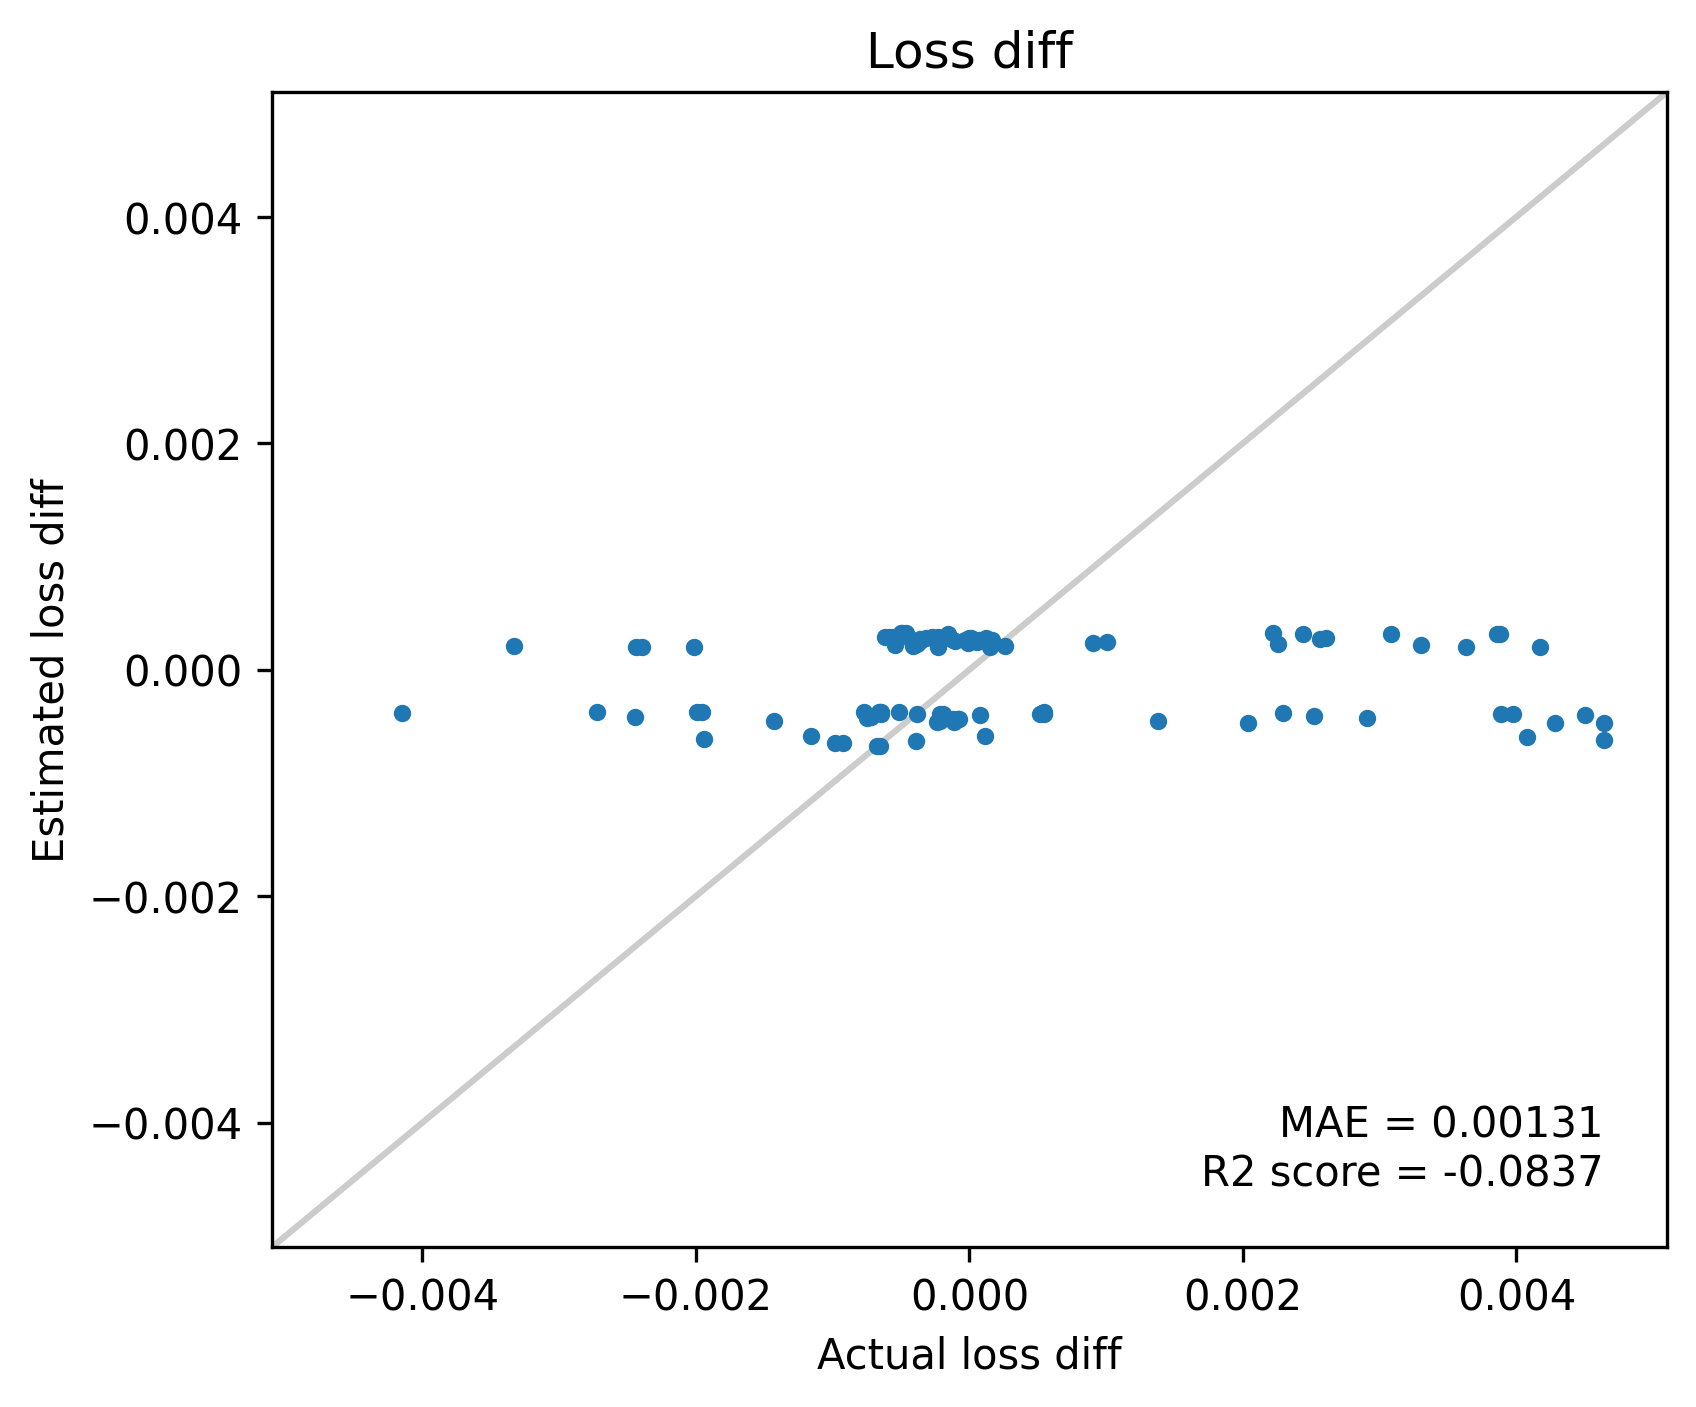

In [17]:
r2_score_ = visualize_result(loss_diff_true, loss_diff_approx)